# Facebook Page Rank

Adjacency matrix. 

### Download fron SNAP

https://snap.stanford.edu/data/facebook-large-page-page-network.html

### Reference

* Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters, Mahoney
  https://arxiv.org/pdf/0810.1355

### Outputs

* `snap_facebook_adj.npy`: adjacency matrix
* `snap_facebook_eig.npy`: eigenvalues of adjacency matrix
* `snap_facebook_eig.pdf`: ESD of adjacency matrix

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse as sp
import matplotlib.pyplot as plt
from os.path import join
import texplot

In [2]:
# Load data
edges = np.loadtxt('./data-facebook/musae_facebook_edges.csv',
                   delimiter=',', skiprows=1, dtype=int)
print(edges.shape)

(171002, 2)


In [3]:
# Compute Adjacency and save

# Find number of nodes (node IDs are 0-indexed)
n_nodes = edges.max() + 1

# Build sparse adjacency matrix
A = scipy.sparse.coo_matrix(
    (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    shape=(n_nodes, n_nodes)
)

# Since the graph is undirected, symmetrize it
A = A + A.T

# Make sure all nonzero entries are 1
A.data = np.ones_like(A.data)

A = A.toarray()
n = A.shape[0]
print(A.shape)
print(sp.issparse(A))

# Center
# n = A.shape[0]
# p = A.sum() / (n*(n-1))      # empirical edge‐probability
# A_c = A - p * np.ones((n, n))

# Laplacian
d = A.sum(axis=1)  # degree vector
D = np.diag(d)
L = D - A

# Symmetric normalized Laplacian:
# L_sym = D^{-1/2} L D^{-1/2}  =  I – D^{-1/2} A D^{-1/2}
# eigenvalues lie in [0,2]
with np.errstate(divide='ignore'):
    d_sqrt_inv = 1.0/np.sqrt(d)
d_sqrt_inv[np.isinf(d_sqrt_inv)] = 0.0
D_sqrt_inv = np.diag(d_sqrt_inv)
I = np.eye(n)
L_sym = I - D_sqrt_inv @ A @ D_sqrt_inv

# Modularity matrix           
m = d.sum()/2
Dd = np.outer(d, d) / (2*m)
B = A - Dd

# Bethe-Hessian
# For the choice of "r", see "Spectral Clustering of Graphs with the Bethe Hessian"
I = np.eye(A.shape[0])
r = np.sqrt(d.mean())
H = (r**2 - 1)*I - r*A + D

# Save
dir_ = './data-tmp'
np.save(join(dir_, 'snap_facebook_adj.npy'), A)
np.save(join(dir_, 'snap_facebook_lap.npy'), L)
np.save(join(dir_, 'snap_facebook_lap_sym.npy'), L_sym)
np.save(join(dir_, 'snap_facebook_mod.npy'), B)
np.save(join(dir_, 'snap_facebook_hes.npy'), H)

(22470, 22470)
False


In [8]:
# Compute eigenvalues of adjacency
eig_adj = np.linalg.eigvalsh(A, UPLO='U')
np.save(join(dir_, 'snap_facebook_adj_eig.npy'), eig_adj)

# Compute eigenvalues of Laplacian
eig_lap = np.linalg.eigvalsh(L, UPLO='U')
np.save(join(dir_, 'snap_facebook_lap_eig.npy'), eig_lap)

# Compute eigenvalues of symmetric Laplacian
eig_lap_sym = np.linalg.eigvalsh(L_sym, UPLO='U')
np.save(join(dir_, 'snap_facebook_lap_sym_eig.npy'), eig_lap_sym)

# Compute eigenvalues of Modularity
eig_mod = np.linalg.eigvalsh(B, UPLO='U')
np.save(join(dir_, 'snap_facebook_mod_eig.npy'), eig_mod)

# Compute eigenvalues of Bethe-Hessian
eig_hes = np.linalg.eigvalsh(H, UPLO='U')
np.save(join(dir_, 'snap_facebook_hes_eig.npy'), eig_hes)

# START HERE
### Start from this point if files above are already saved in ``./data-tmp``

In [4]:
# =================
# hist in log scale
# =================

def hist_in_log_scale(eig, nbins):
    """
    Histogram of a variable itself, but in log scale.
    """
    
    u = np.log10(eig[eig>0])
    bins_u = np.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = np.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = 10.0**u_mid
    density = counts / lambda_
    return density, lambda_

Plot saved to "/home/sia/work/scripts/free_decompression/snap_facebook_eig.pdf".


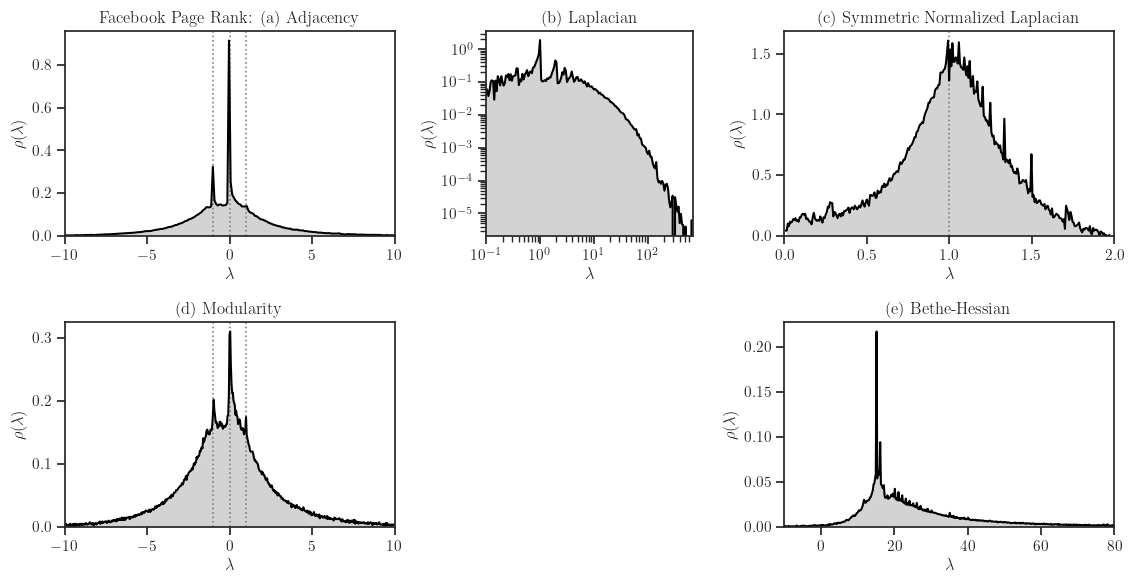

In [5]:
# Plot eigenvalues
dir_ = './data-tmp'
eig_adj = np.load(join(dir_, 'snap_facebook_adj_eig.npy'))
eig_lap = np.load(join(dir_, 'snap_facebook_lap_eig.npy'))
eig_lap_sym = np.load(join(dir_, 'snap_facebook_lap_sym_eig.npy'))
eig_mod = np.load(join(dir_, 'snap_facebook_mod_eig.npy'))
eig_hes = np.load(join(dir_, 'snap_facebook_hes_eig.npy'))

# Clip
eig_adj = eig_adj[np.abs(eig_adj) < 20]
eig_mod = eig_mod[np.abs(eig_mod) < 10]
eig_hes = eig_hes[np.logical_and(eig_hes > -20, eig_hes < 80)]

# Remove spikes
tol = 1e-3
adj_spikes = np.arange(-1, 2)
lap_sym_spikes = [1]
for spike in adj_spikes:
    mask = ~np.isclose(eig_lap_sym, spike, atol=tol)
    eig_lap_sym = eig_lap_sym[mask]

# Remove spikes
tol = 1e-3
lap_sym_spikes = [1]
for spike in lap_sym_spikes:
    mask = ~np.isclose(eig_lap_sym, spike, atol=tol)
    eig_lap_sym = eig_lap_sym[mask]

# Remove spikes
tol = 1e-3
mod_spikes = [-1, 0]
for spike in mod_spikes:
    mask = ~np.isclose(eig_mod, spike, atol=tol)
    eig_mod = eig_mod[mask]

h_adj, bins_adj = np.histogram(eig_adj, 400, density=True)
h_lap, bins_lap_c = hist_in_log_scale(eig_lap, 200)
h_lap_sym, bins_lap_sym = np.histogram(eig_lap_sym, 300, density=True)
h_mod, bins_mod = np.histogram(eig_mod, 500, density=True)
h_hes, bins_hes = np.histogram(eig_hes, 500, density=True)

bins_adj_c = 0.5 * (bins_adj[1:] + bins_adj[:-1])
# bins_lap_c = 0.5 * (bins_lap[1:] + bins_lap[:-1])
bins_lap_sym_c = 0.5 * (bins_lap_sym[1:] + bins_lap_sym[:-1])
bins_mod_c = 0.5 * (bins_mod[1:] + bins_mod[:-1])
bins_hes_c = 0.5 * (bins_hes[1:] + bins_hes[:-1])

with texplot.theme(use_latex=True):
    
    fig = plt.figure(figsize=(11.5, 6))
    gs  = fig.add_gridspec(2, 3, width_ratios=[1.6, 1, 1.6])

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(bins_adj_c, h_adj, color='black')
    ax0.fill_between(bins_adj_c, h_adj, facecolor='lightgray', zorder=-2)

    #  Spike lines
    for spike in adj_spikes:
        ax0.axvline(spike, linestyle=':', linewidth=1.2, color='gray', zorder=-1)

    # ax0.set_yscale('log')
    ax0.set_xlabel(r'$\lambda$')
    ax0.set_ylabel(r'$\rho(\lambda)$')
    ax0.set_title('Facebook Page Rank: (a) Adjacency')
    ax0.set_ylim(bottom=0)
    ax0.set_xlim([-10, 10])

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(bins_lap_c, h_lap, color='black')
    ax1.fill_between(bins_lap_c, h_lap, facecolor='lightgray', zorder=-2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_ylabel(r'$\rho(\lambda)$')
    ax1.set_title('(b) Laplacian')
    ax1.set_ylim(bottom=0)
    ax1.set_xlim([1e-1, bins_lap_c[-1]])

    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(bins_lap_sym_c, h_lap_sym, color='black')
    ax2.fill_between(bins_lap_sym_c, h_lap_sym, facecolor='lightgray', zorder=-2)
    ax2.axvline(1, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    # ax2.set_yscale('log')
    ax2.set_xlabel(r'$\lambda$')
    ax2.set_ylabel(r'$\rho(\lambda)$')
    ax2.set_title('(c) Symmetric Normalized Laplacian')
    ax2.set_xlim([0, 2])
    ax2.set_ylim(bottom=0)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(bins_mod_c, h_mod, color='black')
    ax3.fill_between(bins_mod_c, h_mod, facecolor='lightgray', zorder=-2)
    ax3.axvline(-1, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    ax3.axvline(0, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    ax3.axvline(1, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    # ax3.set_yscale('log')
    ax3.set_xlabel(r'$\lambda$')
    ax3.set_ylabel(r'$\rho(\lambda)$')
    ax3.set_title('(d) Modularity')
    ax3.set_xlim([-10, 10])
    ax3.set_ylim(bottom=0)

    ax4 = fig.add_subplot(gs[1, 2])
    ax4.plot(bins_hes_c, h_hes, color='black')
    ax4.fill_between(bins_hes_c, h_hes, facecolor='lightgray', zorder=-2)
    # ax4.set_yscale('log')
    ax4.set_xlabel(r'$\lambda$')
    ax4.set_ylabel(r'$\rho(\lambda)$')
    ax4.set_title('(e) Bethe-Hessian')
    ax4.set_xlim([-10, 80])
    ax4.set_ylim(bottom=0)

    plt.tight_layout()
    texplot.show_or_save_plot(plt, default_filename='./plots-tmp/snap_facebook_eig.pdf',
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)